In [26]:
import pandas as pd
import numpy as np
import glob, os
from scipy import ndimage 
from skimage import feature
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import cPickle
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


import imp
from PIL import Image
from collections import defaultdict

utils = imp.load_source('utils', '../utils.py')
augment = imp.load_source('augment', '../augment.py')

sns.set_style("whitegrid")

%matplotlib inline

label_numbers =  {"Button":0, "Icon":1, "Image":2, "Input field":3,  "Text":4, "Navigation Menu":5}
number_label = {0:"Button", 1:"Icon", 2:"Image", 3:"Input field",  4:"Text", 5: "Navigation Menu"}

wireframes = ["One Page Website Wireframes", "sketch-psd-wireframe-templates-3", "img2", "img", "ui03", "34b5e120533561.562ece003eee5", "4c553642358074567722f94f3937f101", "WireframeKit-Retina", "b8fe73d7a5d4f27f8833302a7917bc57"]

df = pd.read_csv("log_filtered.csv", sep=",")
#df_all = utils.filter_top_100(pd.read_csv("../../img_labeled/logs/log_all.csv", sep=","))
#df_all = df_all[~df_all.filename.isin(wireframes)]

# Compute additional features and save in .csv
You only need this once!

In [27]:
def contrast(path):
    # Compute the Canny filter for two values of sigma
    img = cv2.imread(path)
    edges = cv2.Canny(img,150,250)
    return np.sum(edges)/(255*float(img.shape[0]*img.shape[1]))

def get_index(f):
    """
    returns index of corresponding row in log dataframe
    """
    k = f.split("_")[0]
    name = ".".join("_".join(f.split("_")[1:]).split(".")[:-1])
    if name in wireframes:
        return -1
    try:
        return df[(df.id == int(k)) & (df.filename == name)].index[0]
    except Exception:        
        return -1

def number_colors(path):
    im = Image.open(path)    
    by_color = defaultdict(int)
    for pixel in im.getdata():
        by_color[pixel] += 1        
    return len([p for p,v in by_color.items() if v >5])

def compute_additional_features(df):
    #1. aspect ratio
    df.loc[:,'aspect_ratio'] = df.width.divide(df.height)

    folder = "../../img_labeled/logs/"
    for f in os.listdir(folder): 
        if f.endswith(".png"):        
            img = utils.read_transposed_image(folder+f)
            i = get_index(f)        
            if not i==-1:            
                label = df.loc[i].label
                ##DO compute features and save to df            
                #2. number of colors                        
                df.loc[i,'n_colors'] = number_colors(folder+f)
                #3. contrast
                df.loc[i,'contrast'] = contrast(folder+f)
    df.to_csv("log_filtered.csv", sep=",")
#df = compute_additional_features(df_all)

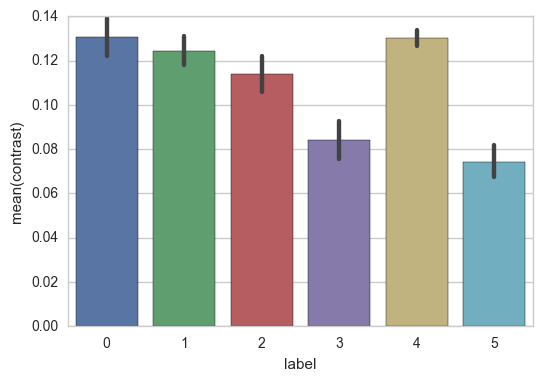

In [28]:
sns.barplot(x="label", y="contrast", data=df)

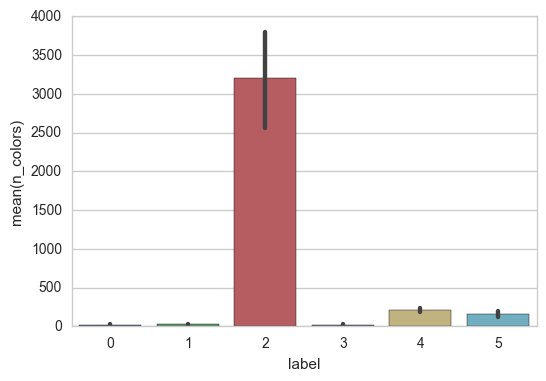

In [29]:
sns.barplot(x="label", y="n_colors", data=df)

In [30]:
def train(clf, df, features, filename=""):
    """
    Function that trains the given classifier on the given data and plots the confusion matrix
    """
    runs = 50
    cm_global = []
    for i in range(0,runs):
        if i%10 ==0:
            print i
        df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
        #Training and test data
        train, test = df[df['is_train']==True], df[df['is_train']==False]
        
        clf.fit(train[features], train.label)

        preds = clf.predict(test[features])
        cm = confusion_matrix(np.array(test.label.tolist()), preds)
        if i == 0:
            cm_global=cm
        else:
            cm_global=np.add(cm_global,cm)
    cm_global = cm_global/50
    cm_global_norm = cm_global.astype('float') / cm_global.sum(axis=1)[:, np.newaxis]

    fig,axes=plt.subplots(2,1) 
    fig.set_size_inches(6,10)
    sns.heatmap(data=cm_global, annot=True, xticklabels=label_numbers.keys(), yticklabels=label_numbers.keys(), ax=axes[0])    
    sns.heatmap(data=cm_global_norm, annot=True, xticklabels=label_numbers.keys(), yticklabels=label_numbers.keys(), ax=axes[1])    
    fig.tight_layout(w_pad=5.0)
    if filename != "":
        fig.savefig(filename,dpi=300, bbox_inches='tight')
    #return last classifier
    return train, test, clf 

0
10
20
30
40


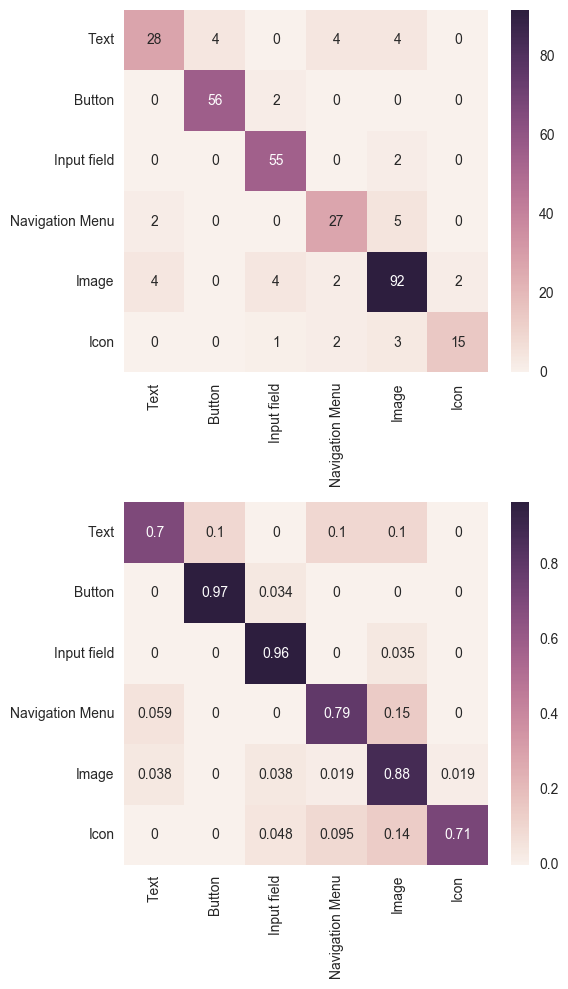

In [31]:
clf = RandomForestClassifier(n_estimators=25, n_jobs=4, criterion="gini", max_features='sqrt')
features = ["x_abs", "y_abs",  "width", "height", "aspect_ratio", "n_colors", "contrast"]        

train, test, clf = train(clf, df, features, "RF_25_gini_noWF_noRelPos.png")

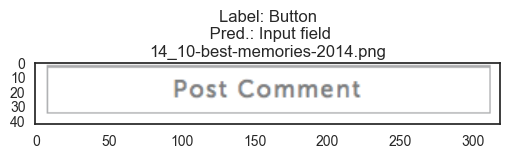

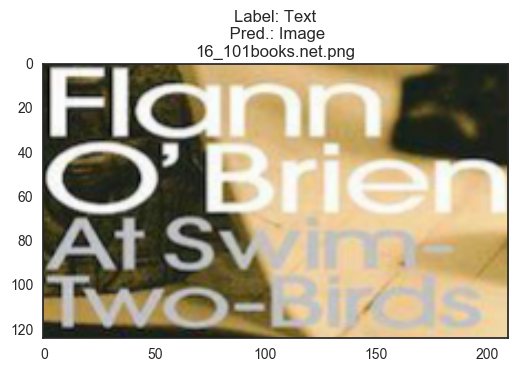

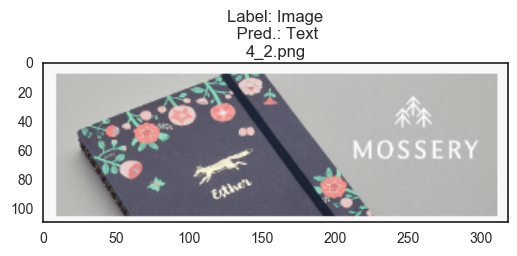

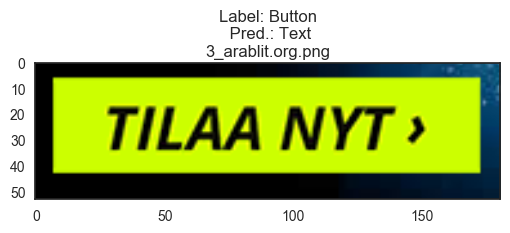

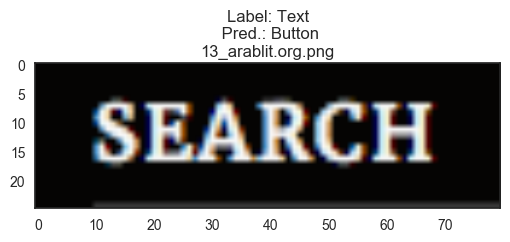

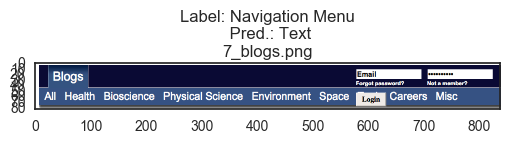

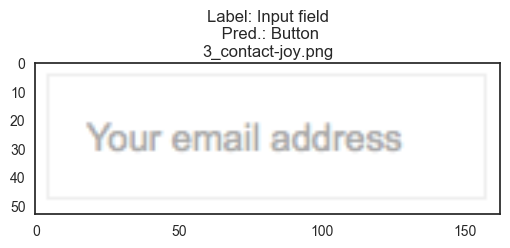

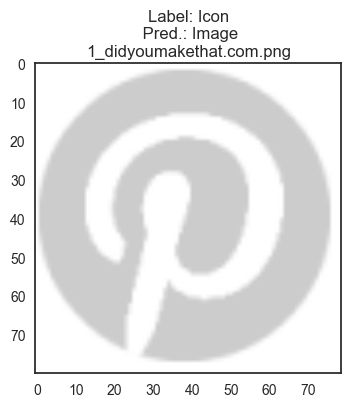

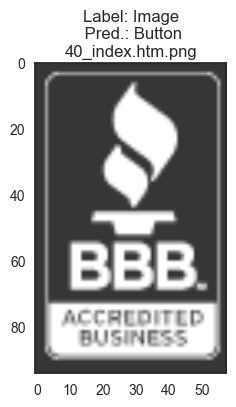

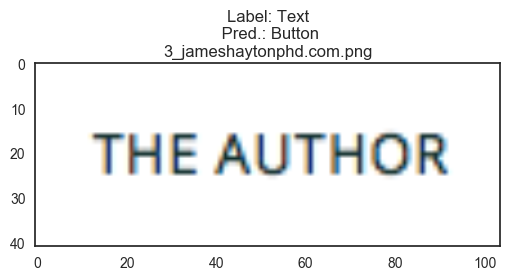

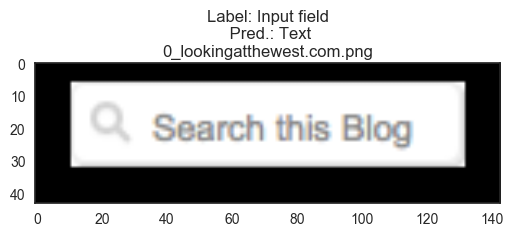

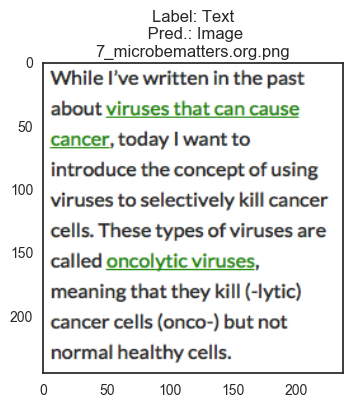

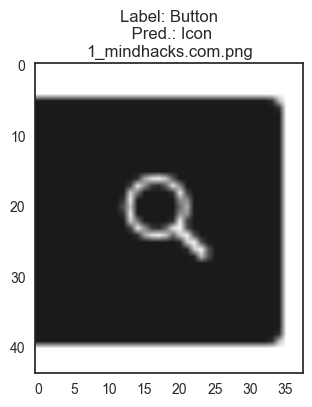

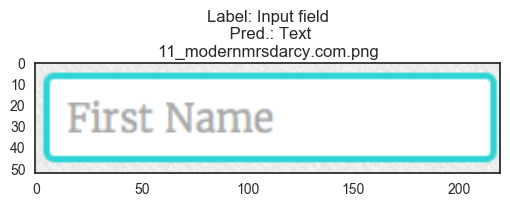

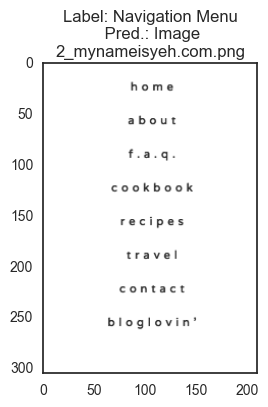

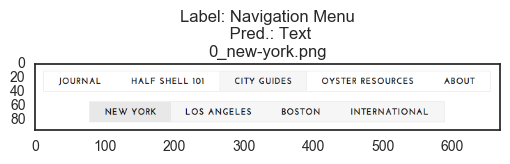

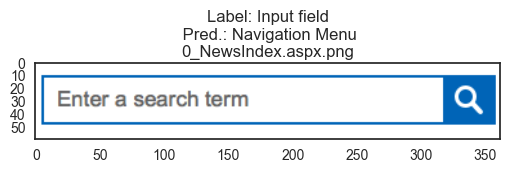

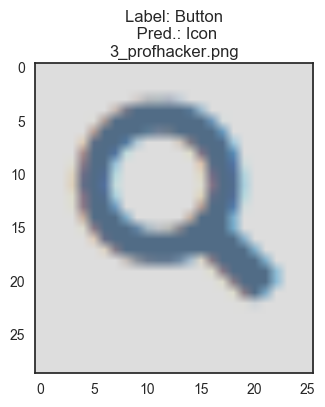

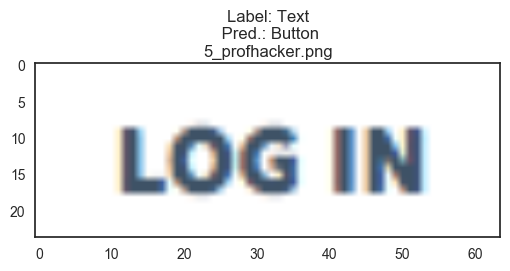

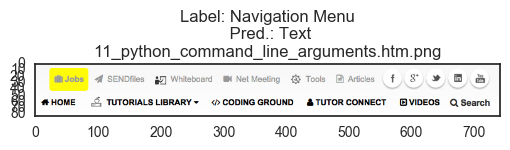

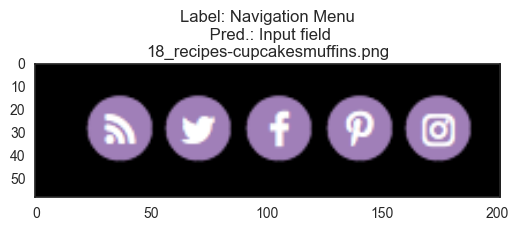

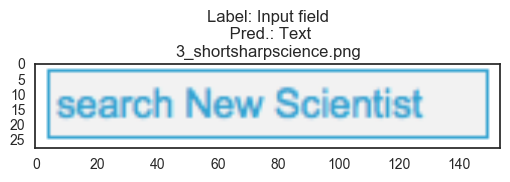

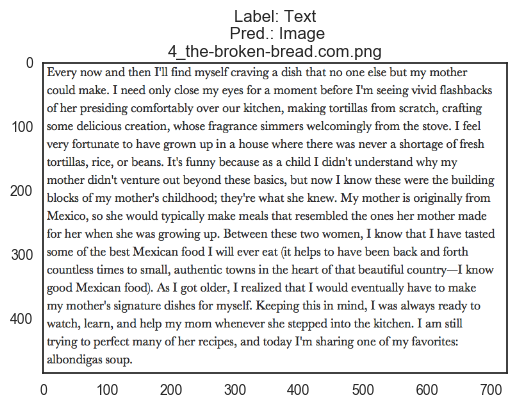

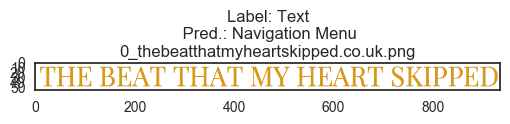

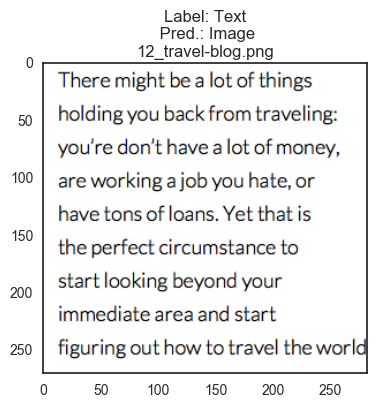

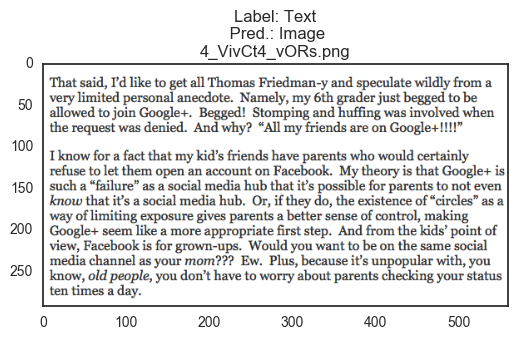

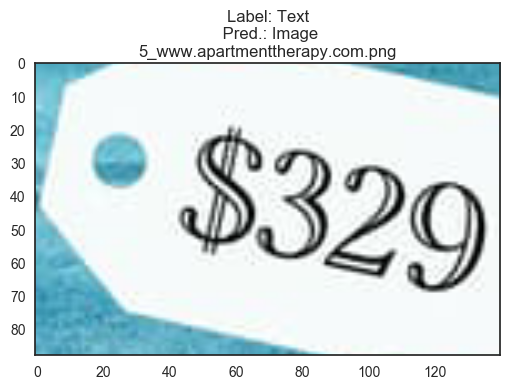

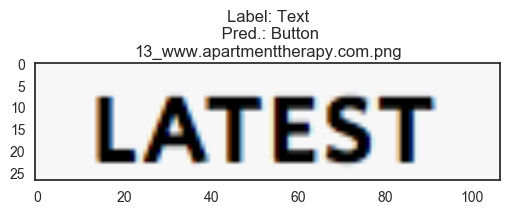

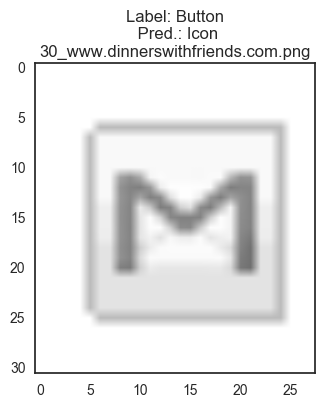

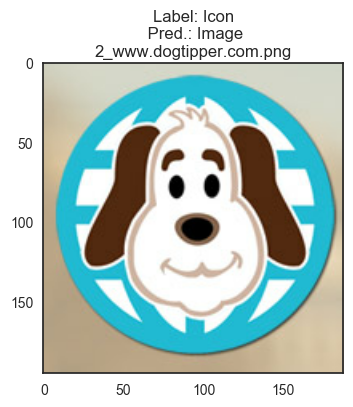

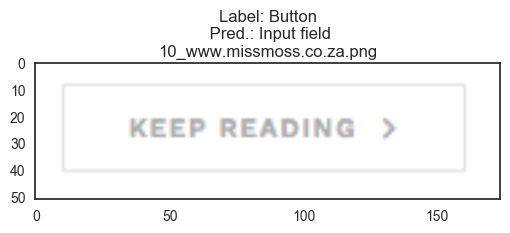

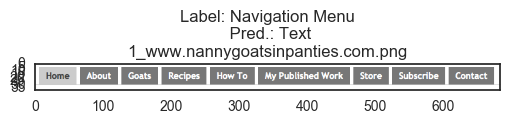

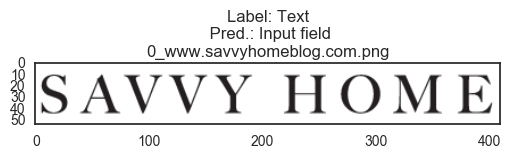

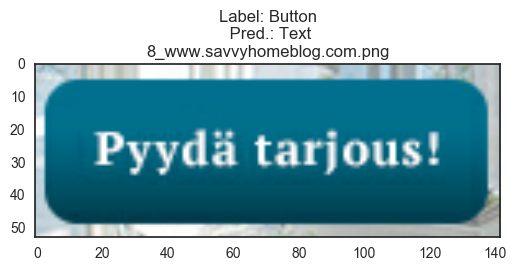

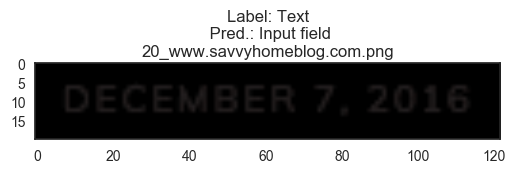

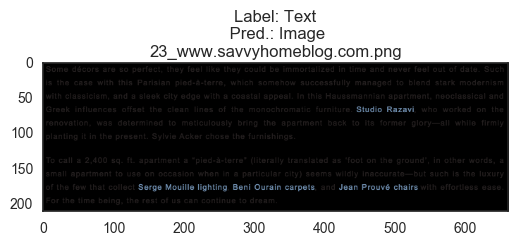

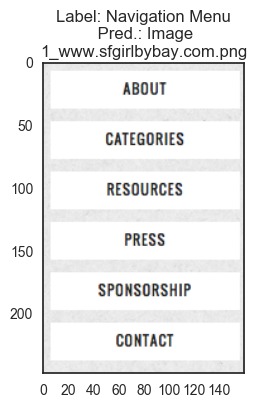

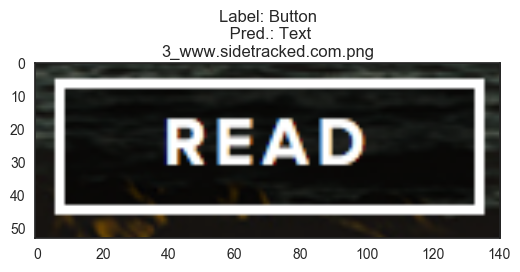

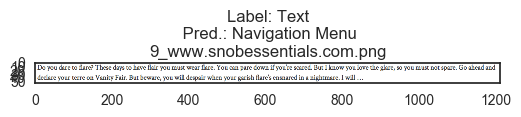

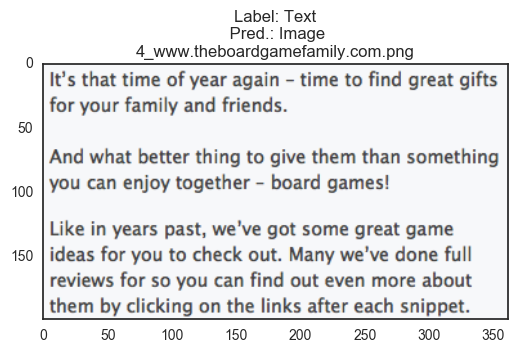

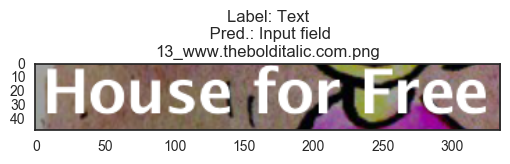

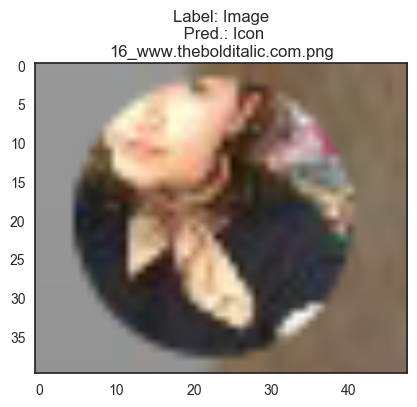

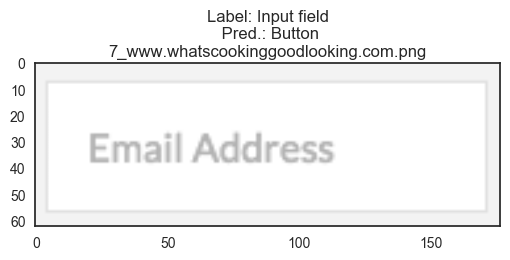

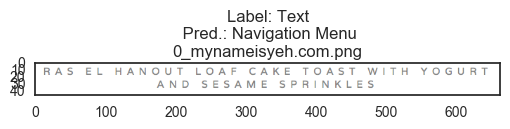

In [37]:
#print wrongly labeled results
preds = clf.predict(test[features])
path = "../../img_labeled/logs/"
for i in range(0,len(test)):
    #FROM TEST
    pred = preds[i]
    label = test.iloc[i].label
    if pred != label:
        img = utils.read_image(path+str(int(test.iloc[i].id))+"_"+test.iloc[i].filename+".png")
        fig,ax = utils.plot_image(img)
        ax.set_title("Label: %s\n Pred.: %s\n%s"%(number_label[label], number_label[pred], str(int(test.iloc[i].id))+"_"+test.iloc[i].filename+".png"))
        fig.savefig("debug/%i_test"%i, bbox_inches="tight")
#FROM TRAIN
preds = clf.predict(train[features])
for i in range(0,len(train)):
    #FROM TEST
    pred = preds[i]
    label = train.iloc[i].label
    if pred != label:
        img = utils.read_image(path+str(int(train.iloc[i].id))+"_"+train.iloc[i].filename+".png")
        fig,ax = utils.plot_image(img)
        ax.set_title("Label: %s\n Pred.: %s\n%s"%(number_label[label], number_label[pred], str(int(train.iloc[i].id))+"_"+train.iloc[i].filename+".png"))
        fig.savefig("debug/%i_train"%i, bbox_inches="tight")
        

(-1, 7)

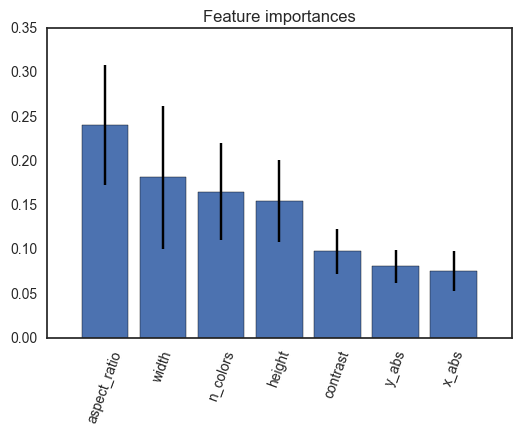

In [38]:
fig,ax=plt.subplots(1)
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
importances = clf.feature_importances_
ax.set_title("Feature importances")
indices = np.argsort(importances)[::-1]

ax.bar(range(len(importances)), importances[indices], yerr=std[indices], align="center", ecolor='k')
ax.set_xticklabels([features[i] for i in indices])
ax.set_xticks(range(len(features)))
plt.xticks(rotation=70)
ax.set_xlim([-1, len(importances)])

# Gaussian process classification

0
10
20
30
40


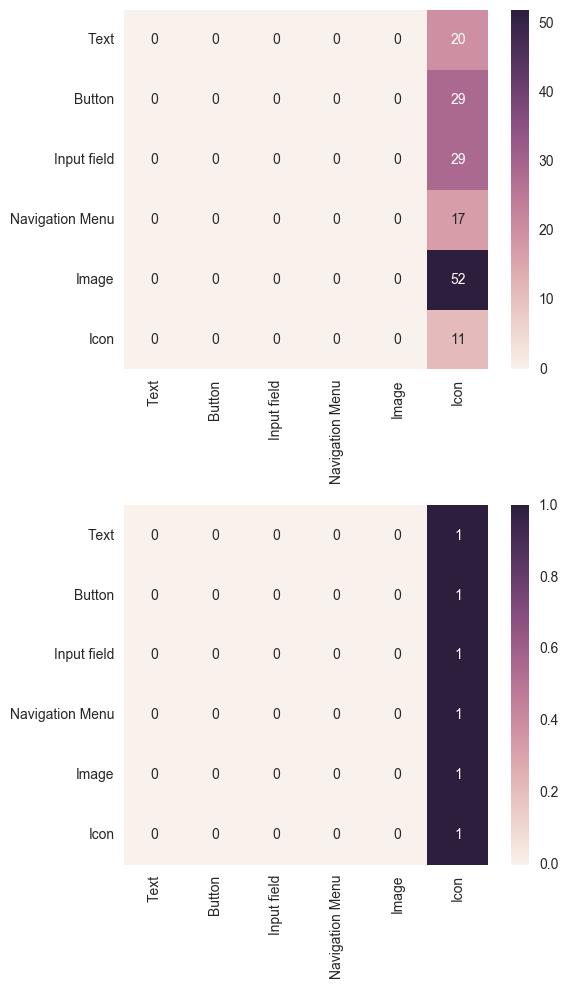

In [196]:
from sklearn.gaussian_process import GaussianProcessClassifier

clf = GaussianProcessClassifier(n_jobs=-1)
features = ["x_abs", "y_abs",  "width", "height", "aspect_ratio", "n_colors", "contrast"]        

train(clf, df, features, "GP_noWF_noRelPos.png")

# K nearest neighbor

0
10
20
30
40


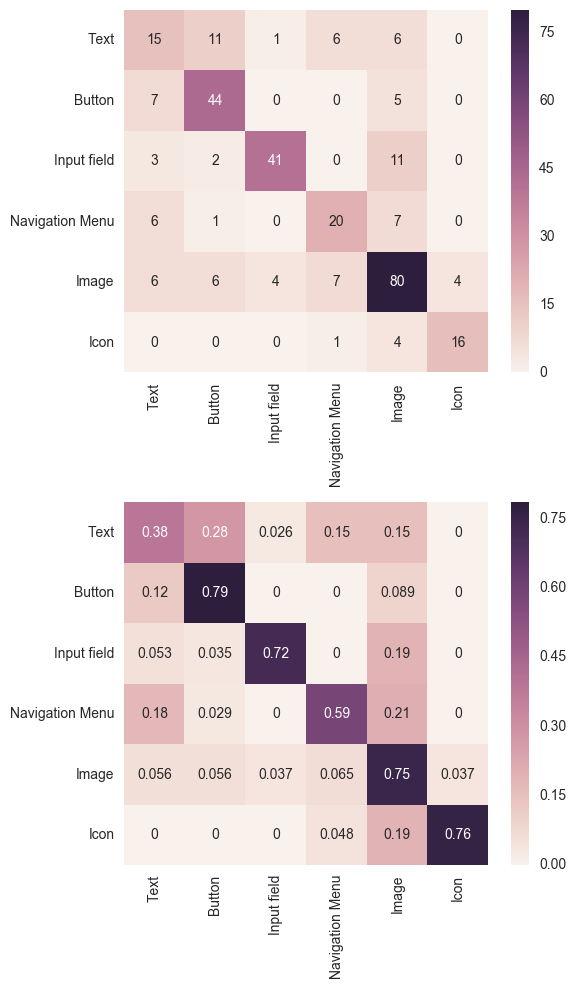

In [201]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(weights='distance', n_jobs=-1)
features = ["x_abs", "y_abs",  "width", "height", "aspect_ratio", "n_colors", "contrast"]        

train(clf, df, features, "KNN_noWF_noRelPos.png")